In [1]:
%load_ext autoreload
%autoreload

In [2]:
from collections import namedtuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from padasip.filters import FilterAP, FilterNLMS, FilterLMS,FilterNLMF, FilterGNGD, FilterNSSLMS, FilterRLS
from padasip.detection import ELBND
from filterpy.kalman import KalmanFilter

In [3]:
data = pd.read_csv('data.csv', header = 0, index_col = 0, parse_dates = [0], infer_datetime_format = True)

In [4]:
data.head()

,Outlet,Inlet_1,Inlet_2,Inlet_3,Inlet_4
DateTime,,,,,
2018-06-28 13:54:00,3202.364500,1398.1035,0.0,0.0,560.544
2018-06-28 13:56:00,3202.589667,1398.3410,0.0,0.0,560.544
2018-06-28 13:58:00,3202.814833,1398.5785,0.0,0.0,560.544
2018-06-28 14:00:00,3203.040000,1398.8160,0.0,0.0,560.544
2018-06-28 14:02:00,3260.256000,1390.7840,0.0,0.0,552.288


In [5]:
Result = namedtuple('Result',['Orig_Data', 'Est', 'Err', 'W', 'ELBND'] )
def regress_combinations(adaptive_filter, data):

    results = dict()
    columns = data.columns
    for col in columns:
        cols = columns.tolist()
        cols.remove(col)
        if col == 'Outlet':
            weights = [1,1,1,1]
        else:
            weights = [1, -1, -1, -1]
        adaptive_filter.init_weights(weights)
        orig_data = data.loc[:,col].values
        est, err, w = adaptive_filter.run(orig_data, data.loc[:,cols].values)
        w = pd.DataFrame(w, columns = cols, index = data.index)
        elbnd = ELBND(w, err, function = 'sum')
        results[col] = Result(orig_data, est, err, w, elbnd)

    return results

In [6]:
def plot_adaptive_results(results, result_type):
    num_results = len(results)
    fig_est = plt.figure(figsize = (15, 10*num_results))
    plt.xlabel('samples - k')
    if result_type == 'Est':
        plt.title("Adapation and Error");
        plt.ylim(0,4000);
        i = 0
        for meas, result in results.items():
            i+=1
            ax = plt.subplot(num_results, 1, i);
            ax.set_ylim(0,4000);
            ax.plot(result.Orig_Data,"b", label=f"{meas} act: target");
            ax.plot(result.Est,"g", label=f"{meas} est: output", alpha = .5);
            ax.legend();

    if result_type == 'W':
        plt.title("Weights")
        i = 0
        for meas, result in results.items():
            i+=1
            ax = plt.subplot(num_results, 1, i);
            title_labels = dict()
            for c in result.W.columns:
                title_labels[c] = result.W[c].mean()
            title = f'{meas} mean weights: {title_labels})'
            ax.set_title(title)
            result.W.plot(ax = ax, ylim = (-10,10));

    if result_type == 'Err':
        plt.title('Err - dB');
        i = 0
        for meas, result in results.items():
            i+=1
            ax = plt.subplot(num_results, 1, i);
            ax.plot(10*np.log10(result.Err**2),color = 'b', label=f"{meas} err: dB"); 
    if result_type == 'ELBND':
        plt.title('ELBND - dB');
        i = 0
        for meas, result in results.items():
            i+=1
            ax = plt.subplot(num_results, 1, i);
            ax.plot(10*np.log10(result.ELBND**2),color = 'b', label=f"{meas} err: dB");        
        
    
    plt.tight_layout();
    plt.show();

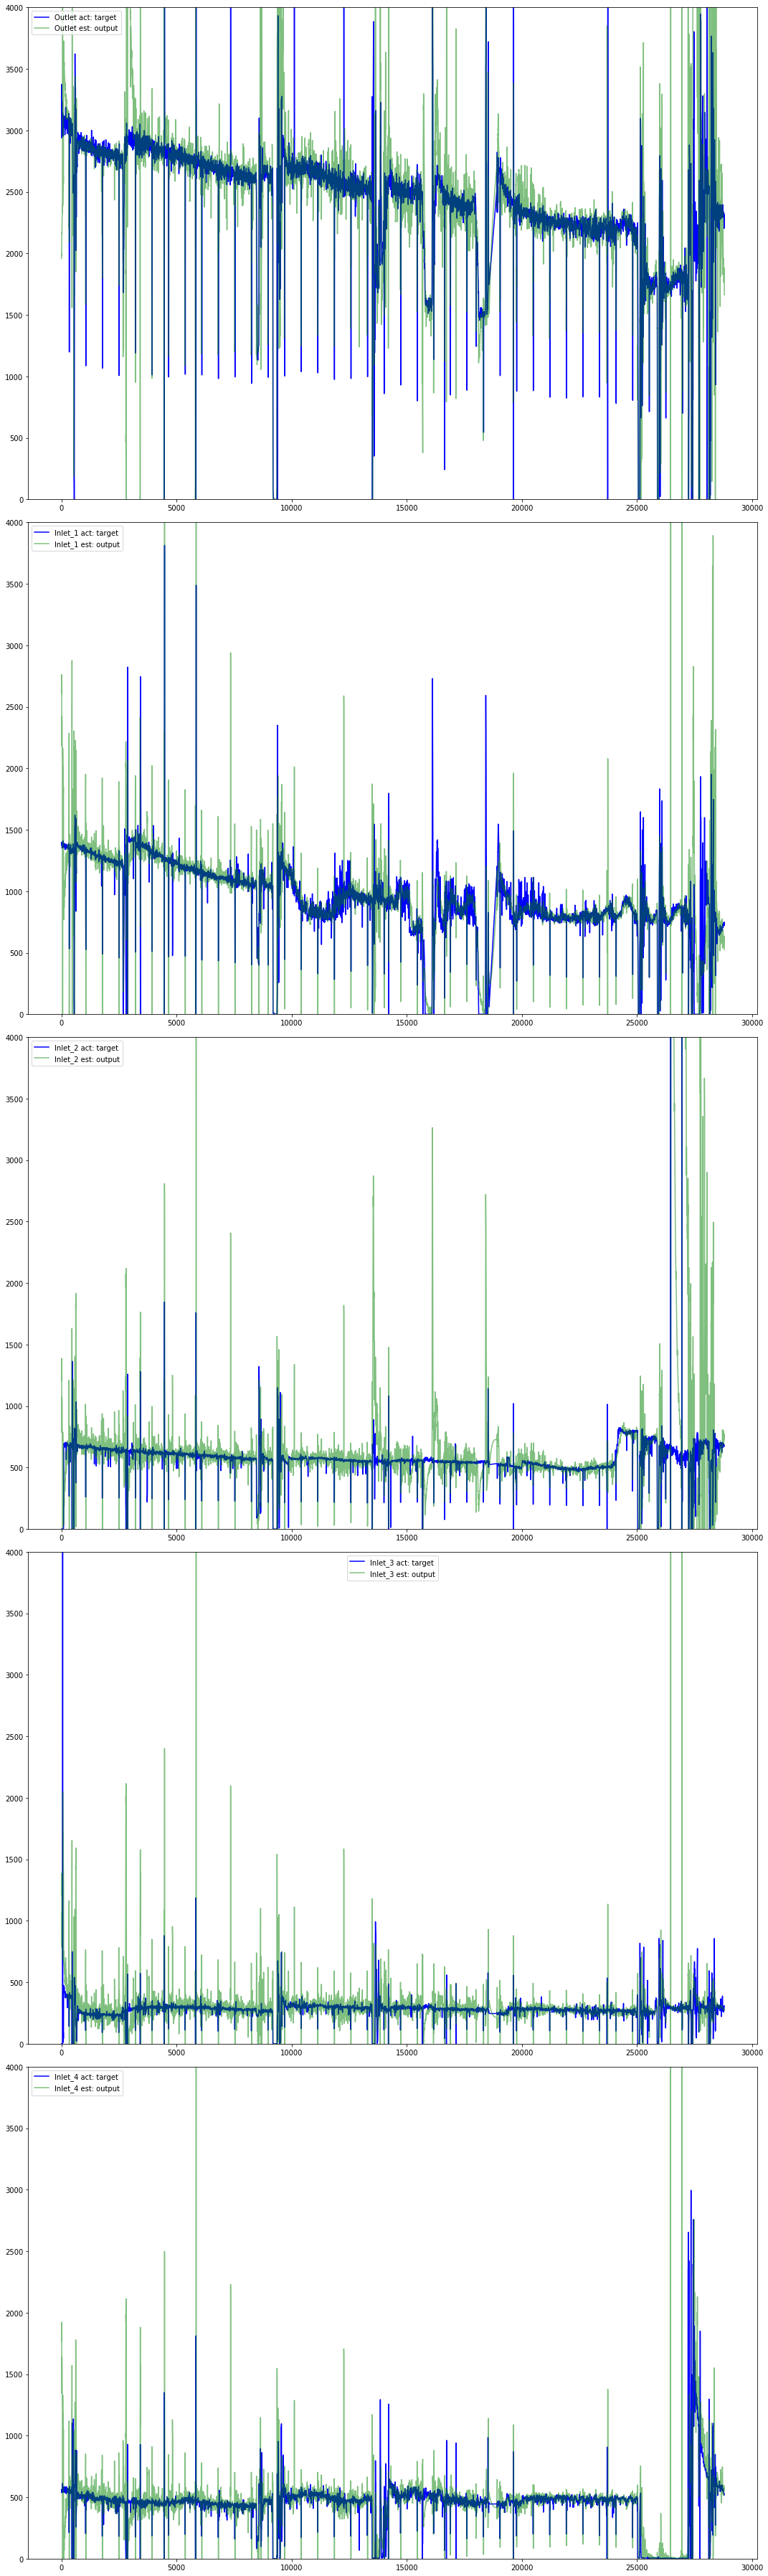

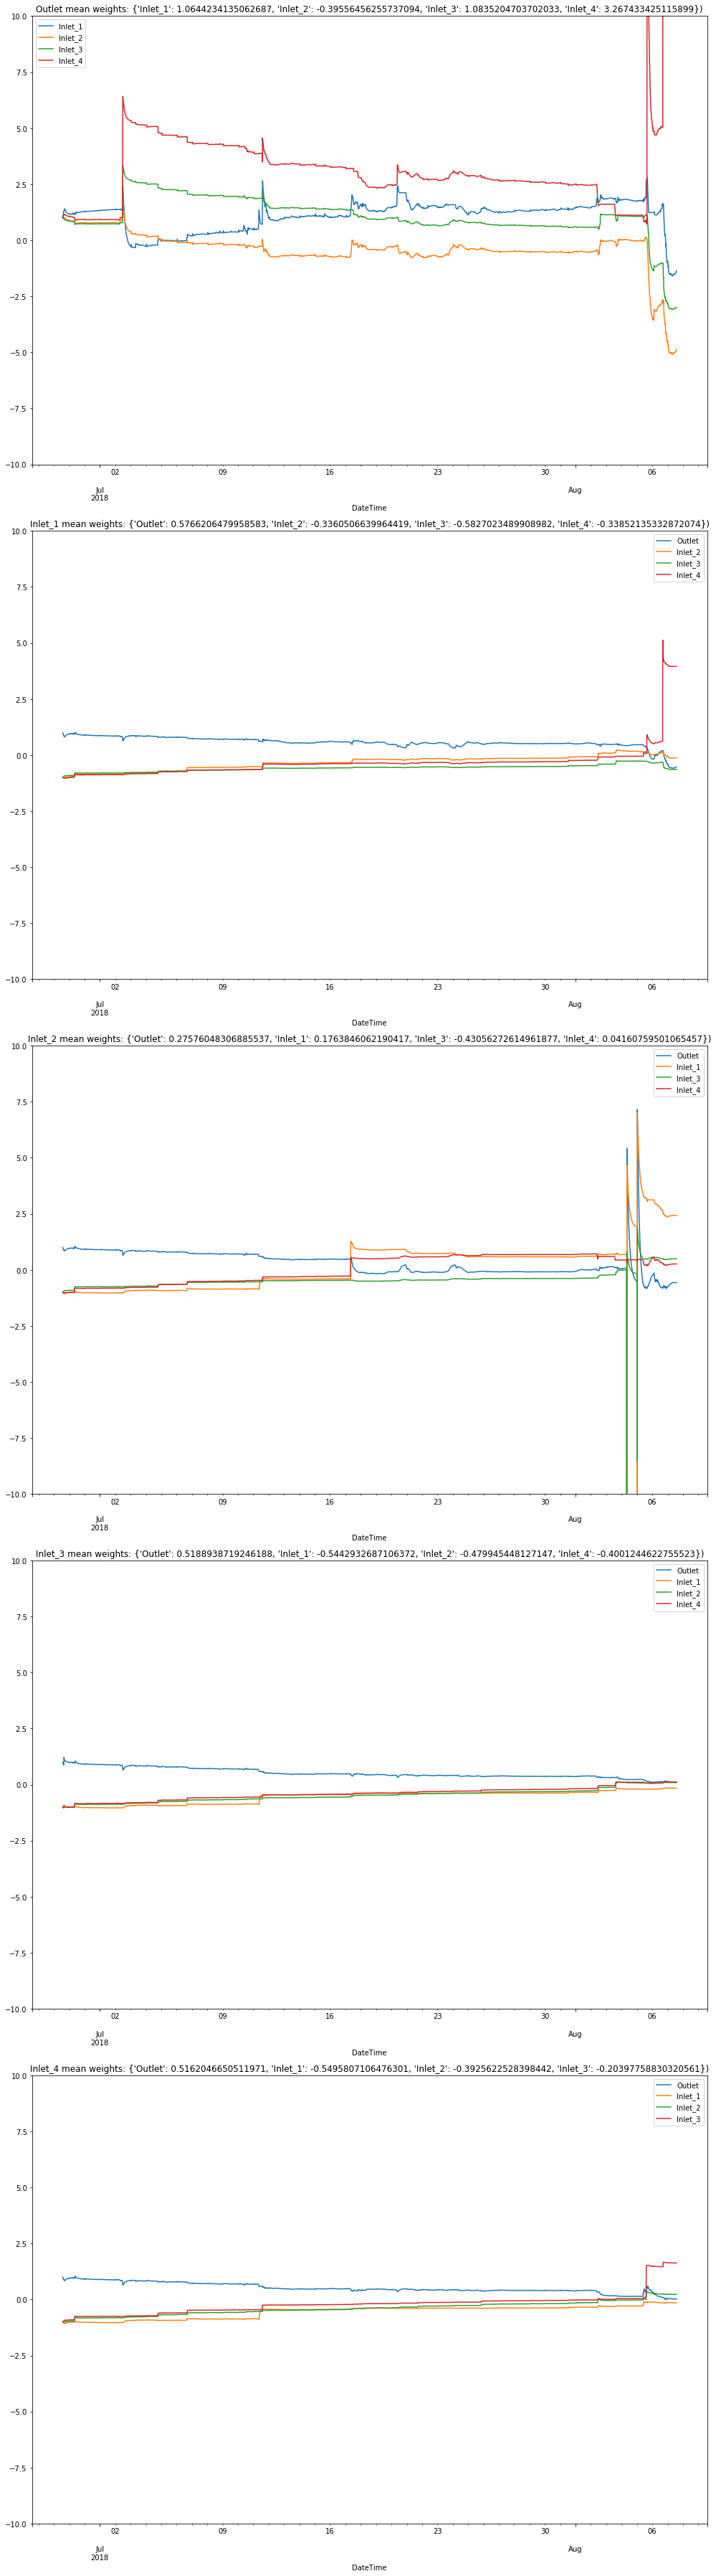

In [7]:
NLMS_filter = FilterNLMS(n=4, mu=0.01, w=[1,1,1,1], eps = 1)
NLMS_results = regress_combinations(NLMS_filter, data)
plot_adaptive_results(NLMS_results, 'Est')
plot_adaptive_results(NLMS_results, 'W')

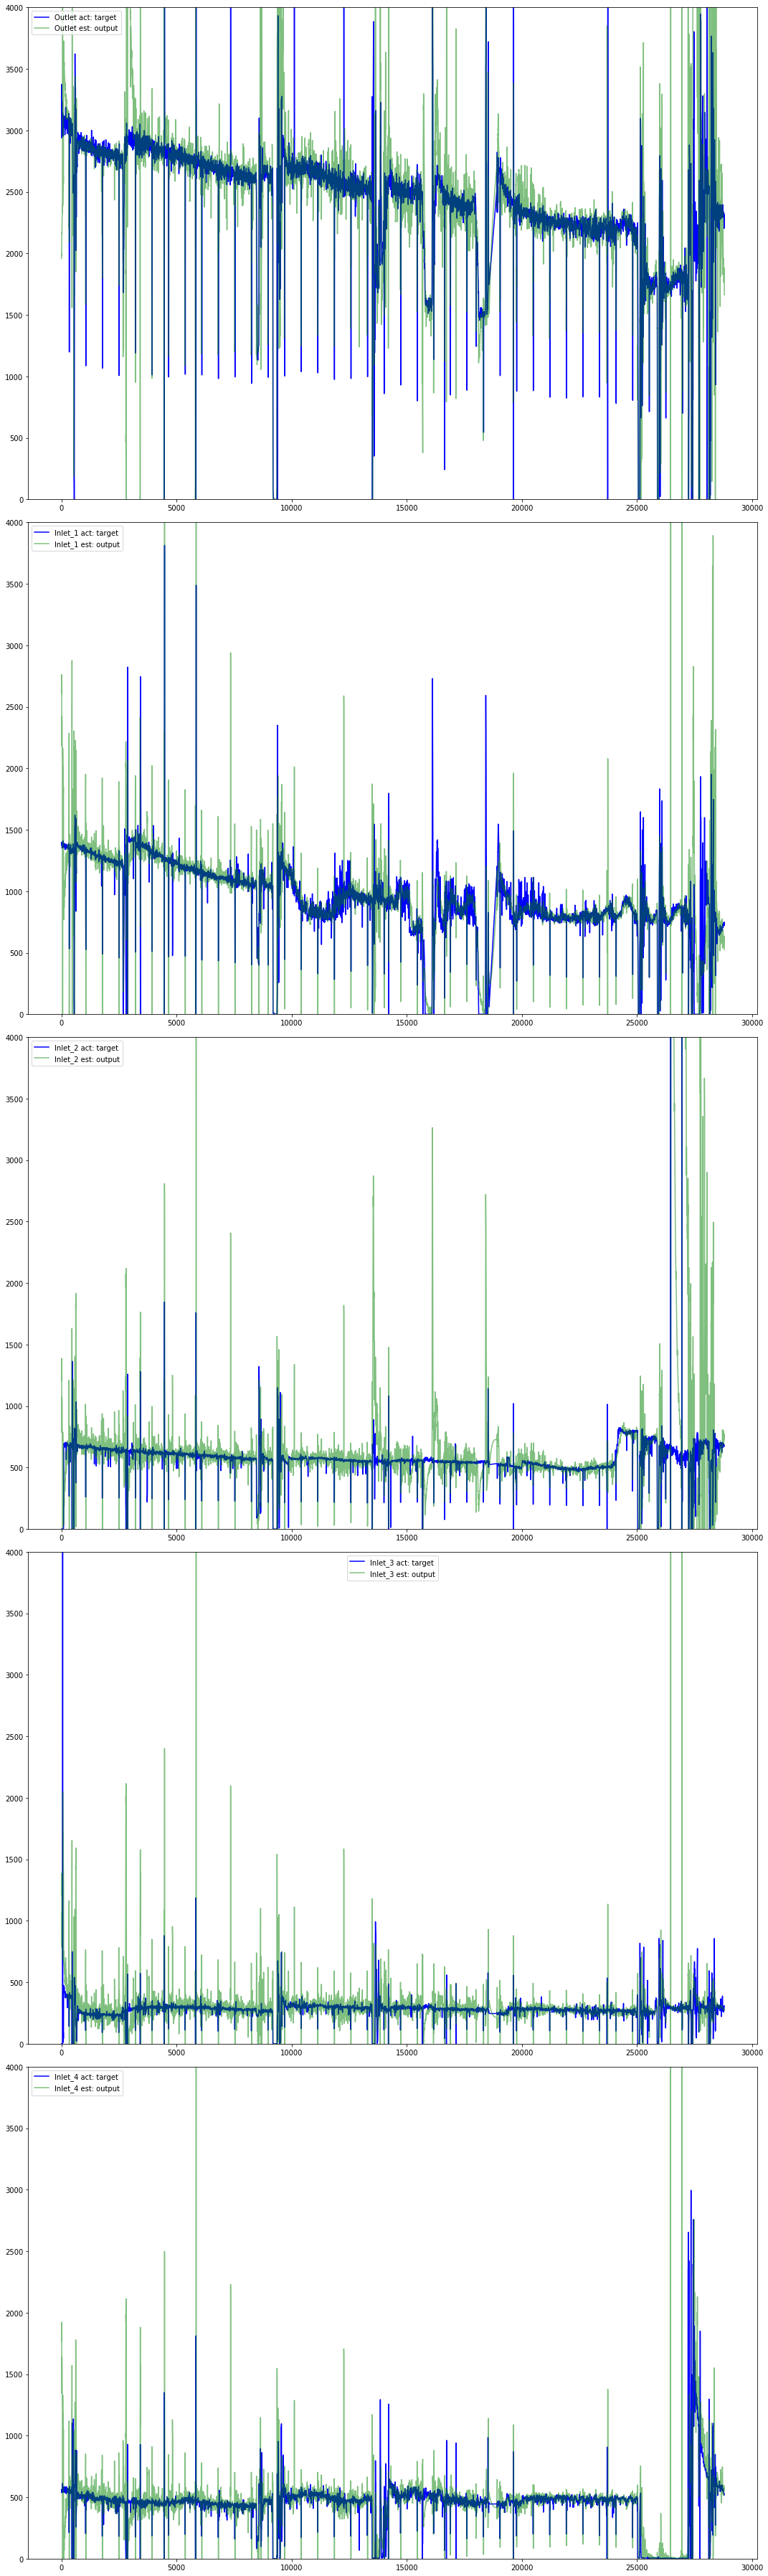

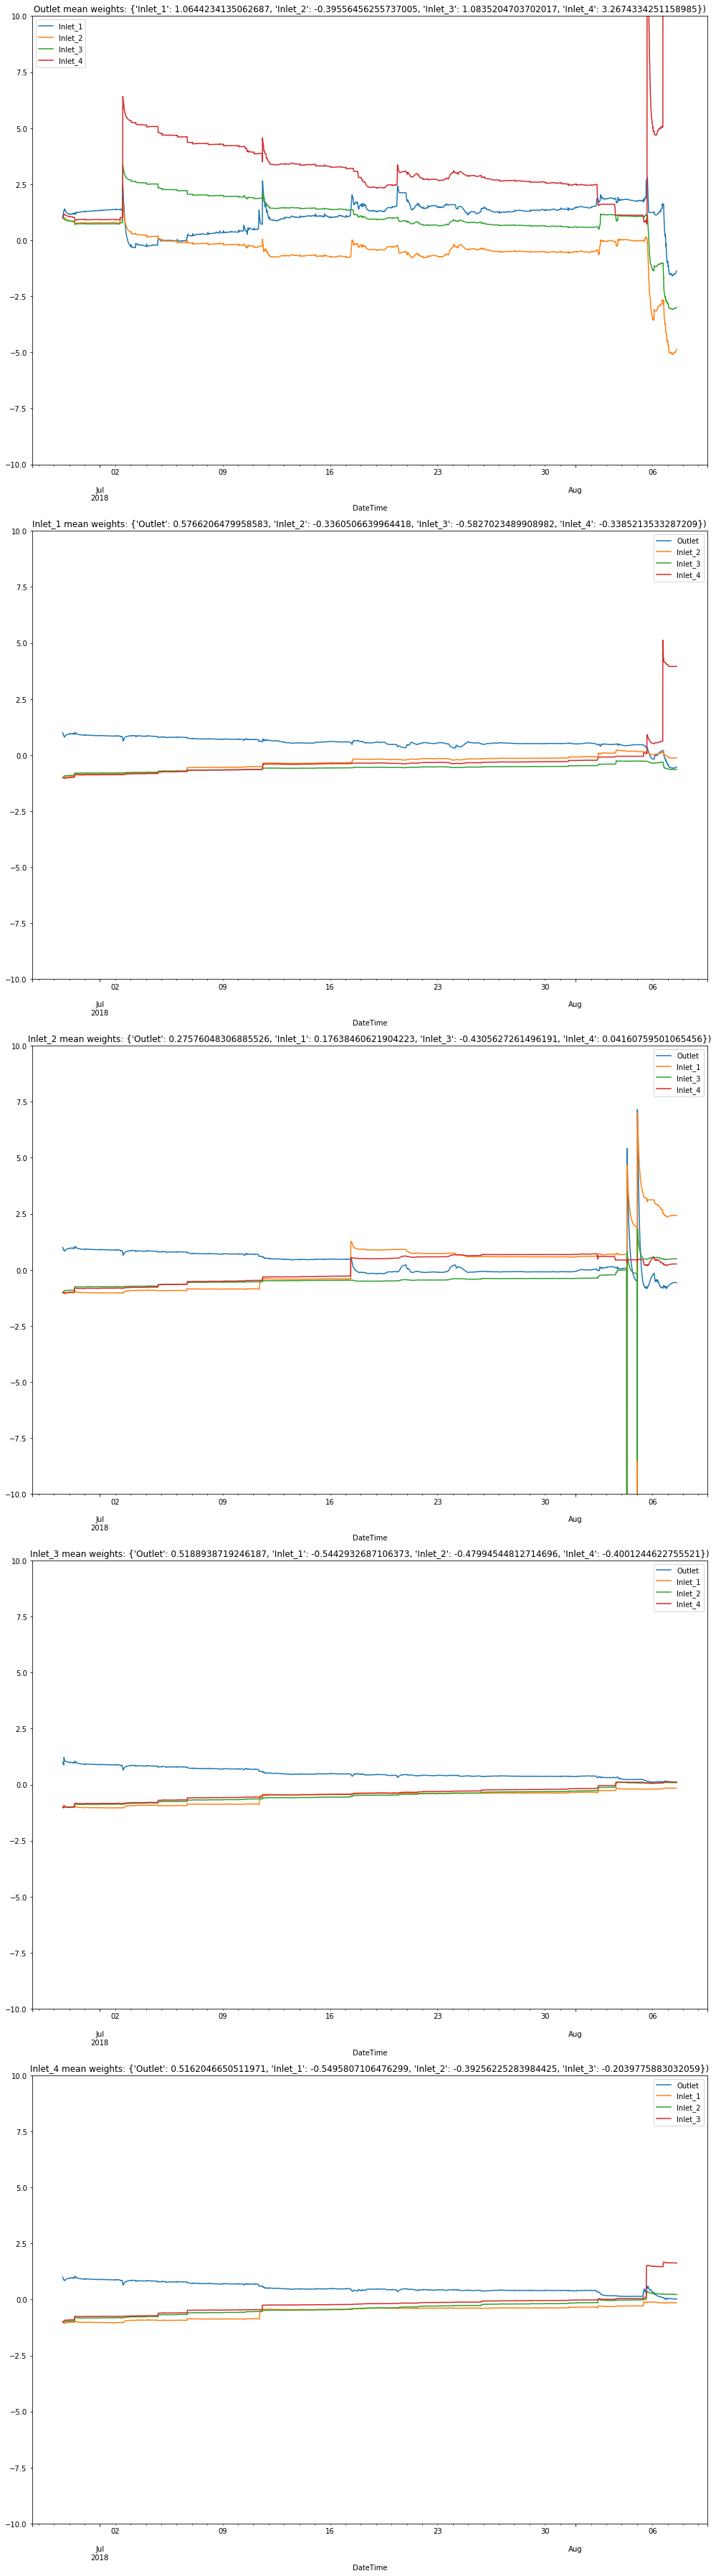

In [8]:
affine_filter = FilterAP(n=4, order = 1, mu=0.01, w=[1,1,1,1], eps = 1)
affine_results = regress_combinations(affine_filter, data)
plot_adaptive_results(affine_results, 'Est')
plot_adaptive_results(affine_results, 'W')

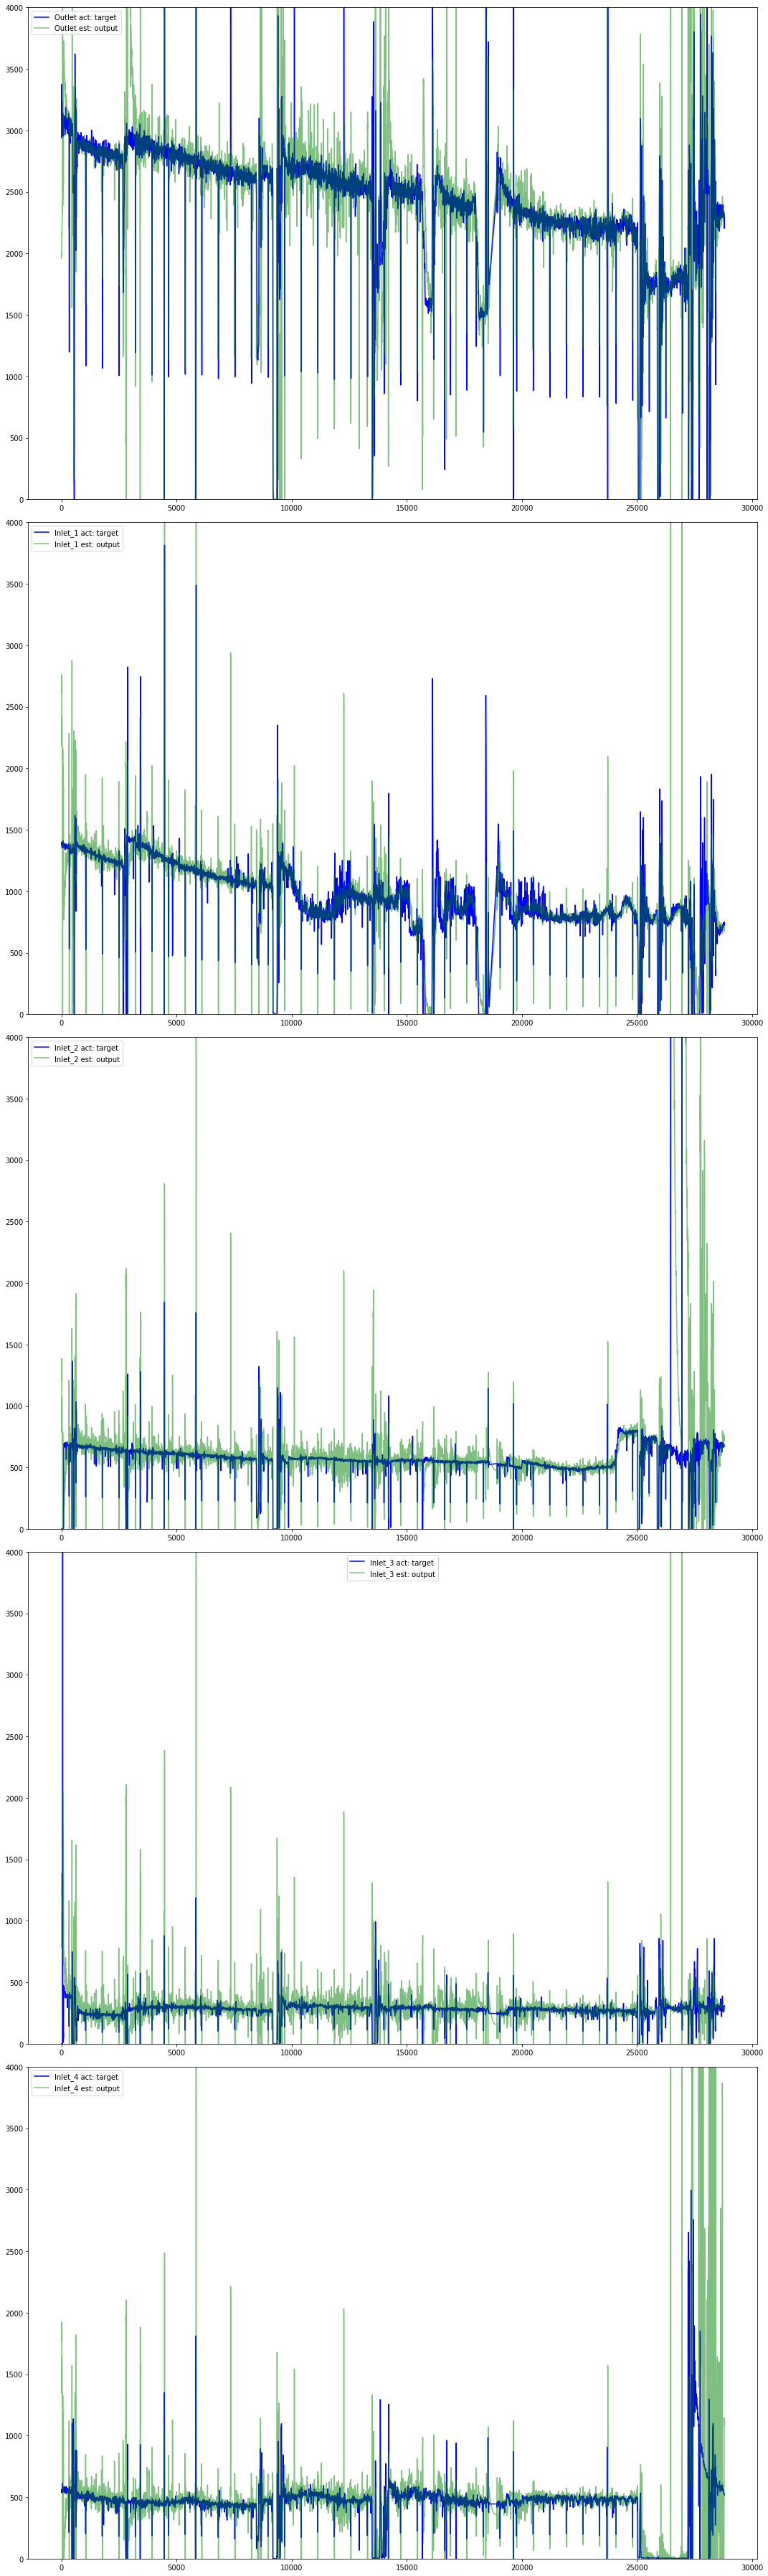

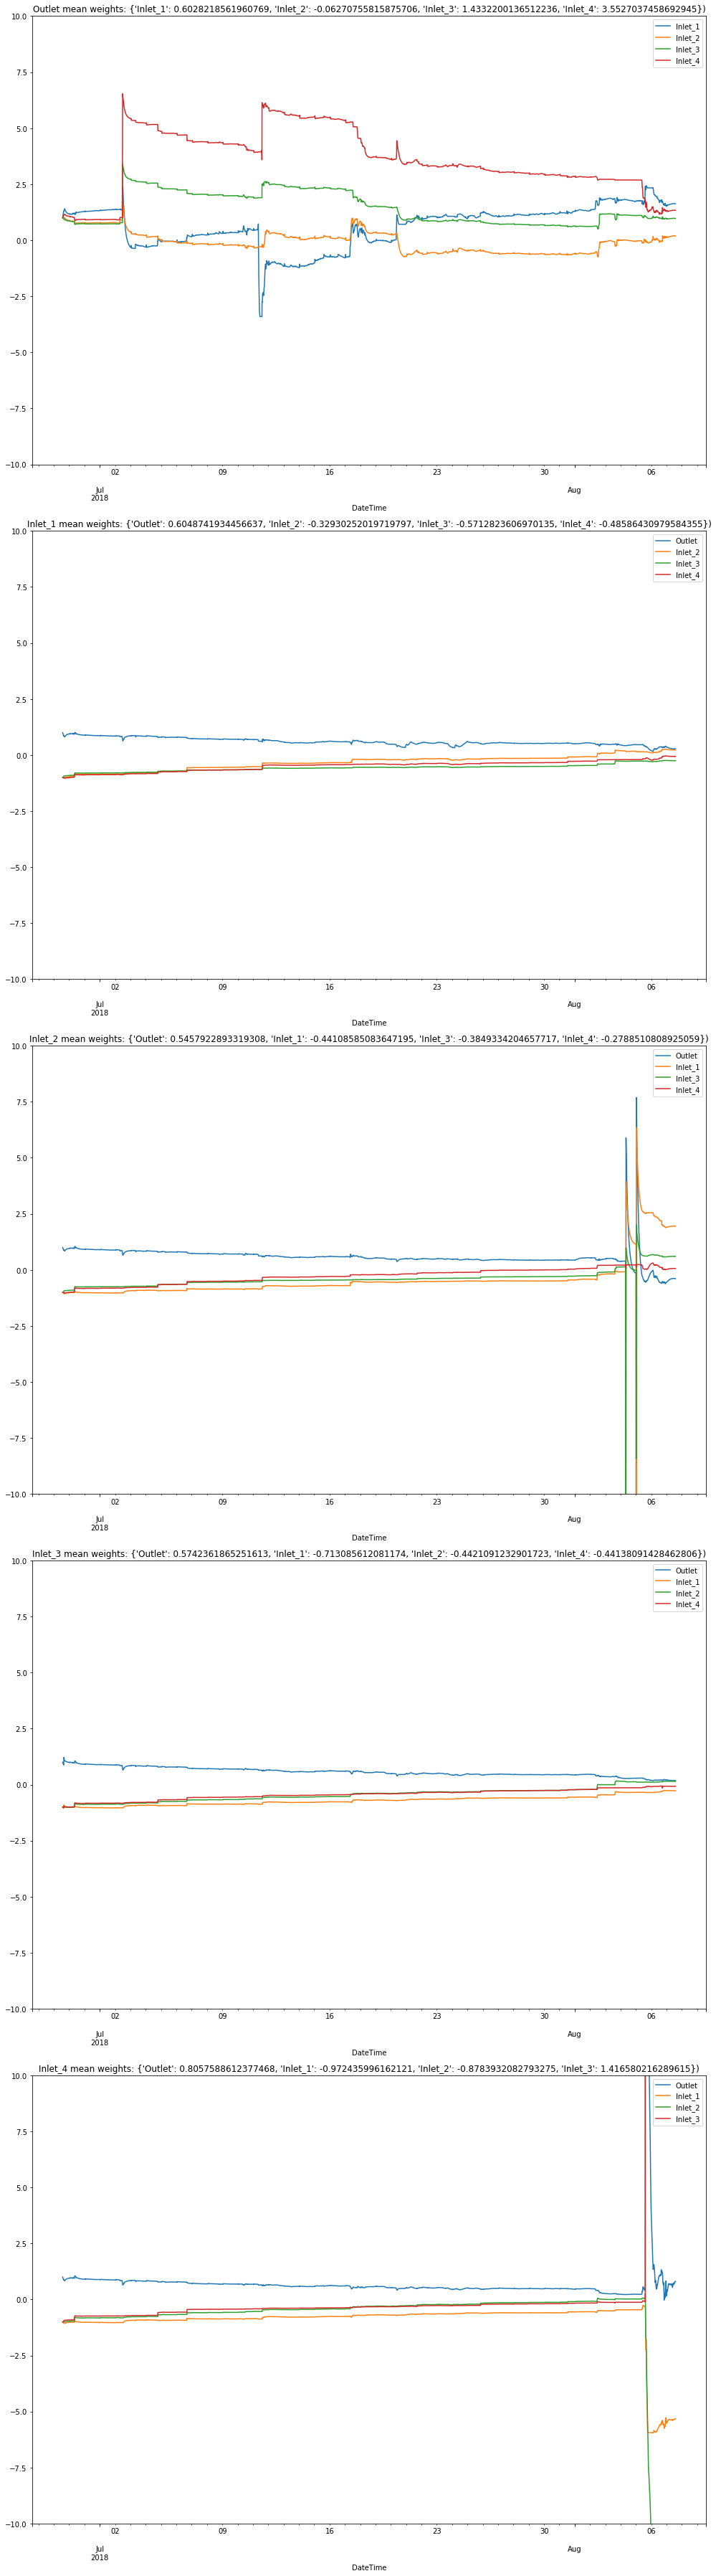

In [9]:
GNGD_filter = FilterGNGD(n=4, mu=0.01, w=[1,1,1,1], eps = 1)
GNGD_results = regress_combinations(GNGD_filter, data)
plot_adaptive_results(GNGD_results, 'Est')
plot_adaptive_results(GNGD_results, 'W')

In [12]:
KalmanResult = namedtuple('KalmanResult',['Orig_Data', 'Est_Data'])
kalman_filter = KalmanFilter(10, 10)

In [44]:
F_columns = []
for col in data.columns:
    F_columns.append(col)
    F_columns.append(f'd{col}_dt')
F = pd.DataFrame(np.diag(np.ones(len(F_columns))), columns = F_columns, index = F_columns)
Q = F.copy(deep = True)
Q = Q*.01

F.head()    

,Outlet,dOutlet_dt,Inlet_1,dInlet_1_dt,Inlet_2,dInlet_2_dt,Inlet_3,dInlet_3_dt,Inlet_4,dInlet_4_dt
Outlet,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dOutlet_dt,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dInlet_1_dt,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
dt = 2
for i in range(0, len(F.columns), 2):
    F.iloc[i,i+1]= dt
F.head()

,Outlet,dOutlet_dt,Inlet_1,dInlet_1_dt,Inlet_2,dInlet_2_dt,Inlet_3,dInlet_3_dt,Inlet_4,dInlet_4_dt
Outlet,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dOutlet_dt,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_1,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
dInlet_1_dt,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_2,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0


In [46]:
R_columns = []
for col in data.columns:
    R_columns.append(f'{col}_meas')
    R_columns.append(f'{col}_est')
    
R = pd.DataFrame(np.diag(np.ones(len(R_columns))), columns = R_columns, index = R_columns)

In [47]:
R.head()

,Outlet_meas,Outlet_est,Inlet_1_meas,Inlet_1_est,Inlet_2_meas,Inlet_2_est,Inlet_3_meas,Inlet_3_est,Inlet_4_meas,Inlet_4_est
Outlet_meas,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Outlet_est,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_1_meas,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_1_est,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Inlet_2_meas,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [48]:
H = pd.DataFrame(0, columns = F.columns, index = R.index)
H.head()

,Outlet,dOutlet_dt,Inlet_1,dInlet_1_dt,Inlet_2,dInlet_2_dt,Inlet_3,dInlet_3_dt,Inlet_4,dInlet_4_dt
Outlet_meas,0,0,0,0,0,0,0,0,0,0
Outlet_est,0,0,0,0,0,0,0,0,0,0
Inlet_1_meas,0,0,0,0,0,0,0,0,0,0
Inlet_1_est,0,0,0,0,0,0,0,0,0,0
Inlet_2_meas,0,0,0,0,0,0,0,0,0,0


In [49]:
for i in range(0,len(H.columns),2):
    H.iloc[i,i] = 1
    H.iloc[i+1, i] = 1
H.head()

,Outlet,dOutlet_dt,Inlet_1,dInlet_1_dt,Inlet_2,dInlet_2_dt,Inlet_3,dInlet_3_dt,Inlet_4,dInlet_4_dt
Outlet_meas,1,0,0,0,0,0,0,0,0,0
Outlet_est,1,0,0,0,0,0,0,0,0,0
Inlet_1_meas,0,0,1,0,0,0,0,0,0,0
Inlet_1_est,0,0,1,0,0,0,0,0,0,0
Inlet_2_meas,0,0,0,0,1,0,0,0,0,0


In [50]:
kalman_filter.H = H.values
kalman_filter.Q = Q.values
kalamn_filter.R = R.values

In [52]:
kalman_data = data.copy(deep = True)

In [24]:
kalman_data['Outlet_est'] = kalman_data.loc[:,['Inlet_1_meas','Inlet_2_meas','Inlet_3_meas', 'Inlet_4_meas']].sum(axis = 1)
kalman_data['Inlet_1_est'] = kalman_data.Outlet_est - kalman_data.loc[:,['Inlet_2_meas','Inlet_3_meas', 'Inlet_4_meas']].sum(axis = 1)
kalman_data['Inlet_2_est'] = kalman_data.Outlet_est - kalman_data.loc[:,['Inlet_1_meas','Inlet_3_meas', 'Inlet_4_meas']].sum(axis = 1)
kalman_data['Inlet_3_est'] = kalman_data.Outlet_est - kalman_data.loc[:,['Inlet_1_meas','Inlet_2_meas', 'Inlet_4_meas']].sum(axis = 1)
kalman_data['Inlet_4_est'] = kalman_data.Outlet_est - kalman_data.loc[:,['Inlet_1_meas','Inlet_2_meas', 'Inlet_3_meas']].sum(axis = 1)

In [25]:
kalman_data = kalman_data[['Outlet_meas', 'Outlet_est', 'Inlet_1_meas', 'Inlet_1_est',
       'Inlet_2_meas', 'Inlet_2_est', 'Inlet_3_meas', 'Inlet_3_est',
       'Inlet_4_meas', 'Inlet_4_est']]
kalman_data.head()

,Outlet_meas,Outlet_est,Inlet_1_meas,Inlet_1_est,Inlet_2_meas,Inlet_2_est,Inlet_3_meas,Inlet_3_est,Inlet_4_meas,Inlet_4_est
DateTime,,,,,,,,,,
2018-06-28 13:54:00,3202.364500,1958.6475,1398.1035,1398.1035,0.0,0.0,0.0,0.0,560.544,560.544
2018-06-28 13:56:00,3202.589667,1958.8850,1398.3410,1398.3410,0.0,0.0,0.0,0.0,560.544,560.544
2018-06-28 13:58:00,3202.814833,1959.1225,1398.5785,1398.5785,0.0,0.0,0.0,0.0,560.544,560.544
2018-06-28 14:00:00,3203.040000,1959.3600,1398.8160,1398.8160,0.0,0.0,0.0,0.0,560.544,560.544
2018-06-28 14:02:00,3260.256000,1943.0720,1390.7840,1390.7840,0.0,0.0,0.0,0.0,552.288,552.288


In [26]:
x = kalman_filter.batch_filter(kalman_data.values)

In [53]:
x = x[:,:,0]

In [58]:
X = pd.DataFrame(x, columns = F.columns, index = kalman_data.index)
X.head()

,Outlet,dOutlet_dt,Inlet_1,dInlet_1_dt,Inlet_2,dInlet_2_dt,Inlet_3,dInlet_3_dt,Inlet_4,dInlet_4_dt
DateTime,,,,,,,,,,
2018-06-28 13:54:00,2064.404800,0.0,1118.482800,0.0,0.0,0.0,0.0,0.0,448.435200,0.0
2018-06-28 13:56:00,2444.860351,0.0,1324.694105,0.0,0.0,0.0,0.0,0.0,531.041684,0.0
2018-06-28 13:58:00,2544.545315,0.0,1378.806620,0.0,0.0,0.0,0.0,0.0,552.649014,0.0
2018-06-28 14:00:00,2571.379311,0.0,1393.454996,0.0,0.0,0.0,0.0,0.0,558.428740,0.0
2018-06-28 14:02:00,2593.549296,0.0,1391.499687,0.0,0.0,0.0,0.0,0.0,553.933395,0.0


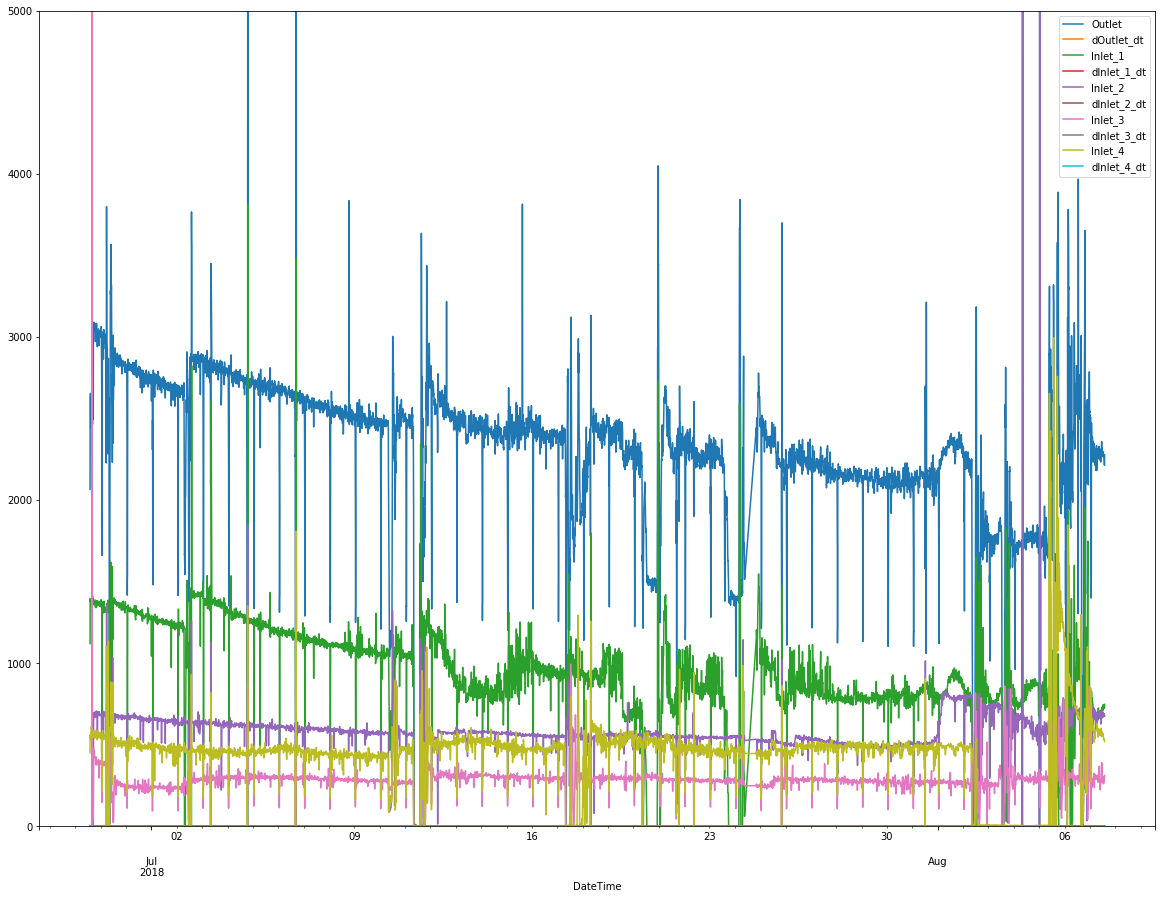

In [61]:
X.plot(figsize = (20,15), ylim=(0,5000))